# Task 3: Helper notebook for loading the data and saving the predictions

In [161]:
from utils import *
from models import *
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import random
from tqdm import tqdm

In [190]:
def plot_training_data(X):
    image_number = random.randint(0, len(X)-1)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(X[image_number], cmap='gray')
    plt.subplot(122)
    plt.imshow(y[image_number], cmap='gray')
    plt.show()
    
def plot_validation_data(X, y, y_pred_thresholded, y_pred):
    image_number = random.randint(0, len(X)-1)
    plt.figure(figsize=(12, 6))
    plt.subplot(141)
    plt.imshow(X[image_number], cmap='gray')
    plt.subplot(142)
    plt.imshow(y[image_number], cmap='gray')
    plt.subplot(143)
    plt.imshow(y_pred_thresholded[image_number], cmap='gray')
    plt.subplot(144)
    plt.imshow(y_pred[image_number], cmap='gray')
    plt.show()
    
def plot_test_data(X, y_pred_thresholded):
    image_number = random.randint(0, X.shape[2]-1)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(X[:, :, image_number], cmap='gray')
    plt.subplot(122)
    plt.imshow(y_pred_thresholded[:, :, image_number], cmap='gray')
    plt.show()

def plot_loss(history):
    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

### Load data

In [2]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
X, y = image_size_normalize(train_data, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

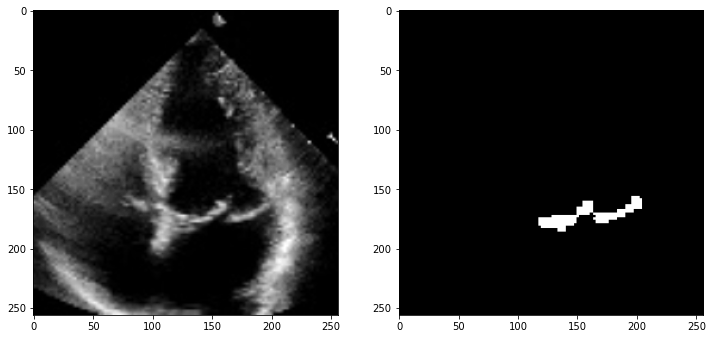

In [118]:
plot_training_data(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [68]:
model = get_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
history = model.fit(X_train, y_train, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/15
16/16 [==============================] - 49s 3s/step - loss: 0.2405 - accuracy: 0.9789 - val_loss: 0.1185 - val_accuracy: 0.9904
Epoch 2/15
16/16 [==============================] - 52s 3s/step - loss: 0.0633 - accuracy: 0.9913 - val_loss: 0.0618 - val_accuracy: 0.9904
Epoch 3/15
16/16 [==============================] - 43s 3s/step - loss: 0.0455 - accuracy: 0.9913 - val_loss: 0.0500 - val_accuracy: 0.9904
Epoch 4/15
16/16 [==============================] - 43s 3s/step - loss: 0.0335 - accuracy: 0.9913 - val_loss: 0.0308 - val_accuracy: 0.9904
Epoch 5/15
16/16 [==============================] - 46s 3s/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9904
Epoch 6/15
16/16 [==============================] - 46s 3s/step - loss: 0.0217 - accuracy: 0.9913 - val_loss: 0.0246 - val_accuracy: 0.9904
Epoch 7/15
16/16 [==============================] - 43s 3s/step - loss: 0.0196 - accuracy: 0.9913 - val_loss: 0.0225 - val_accuracy: 0.9904
Epoch 8/15
16/16 [==

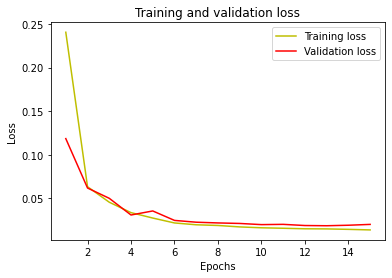

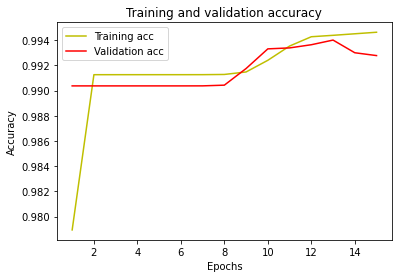

In [119]:
plot_loss(history)

In [166]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

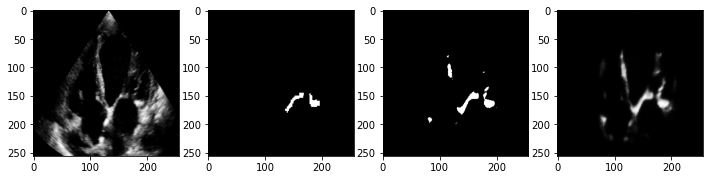

In [387]:
plot_validation_data(X_test, y_test, y_pred_thresholded, y_pred)

In [172]:
def evaluate(prediction, target):
    ious = []
    prediction = prediction.astype(bool)
    target = target.astype(bool)
    for i in range(prediction.shape[0]):

        overlap = prediction[i]*target[i]
        union = prediction[i] + target[i]
        iou = overlap.sum()/float(union.sum())
        ious.append(iou)
    return np.median(ious)

In [173]:
evaluate(y_pred_thresholded, y_test)

0.4976470588235294

In [335]:
predictions = []
for d in tqdm(test_data):
    res = []
    for index in range(d['video'].shape[2]):
        test_img = cv2.resize(d['video'][:, :, index],(IMG_HEIGHT, IMG_WIDTH)).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
        mask = (model.predict(test_img) > 0.5).reshape(IMG_HEIGHT, IMG_WIDTH).astype(float)
        mask = cv2.resize(mask,(d['video'].shape[1], d['video'].shape[0]), interpolation = cv2.INTER_NEAREST)
        res.append(mask)
    res = np.swapaxes(np.swapaxes(np.array(res), 0, 2), 0, 1)
    assert res.shape == d['video'].shape
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': res.astype(bool)
        }
    )

100%|███████████████████████████████████████████| 20/20 [03:04<00:00,  9.21s/it]


In [336]:
predictions[0]['prediction'].shape

(583, 863, 84)

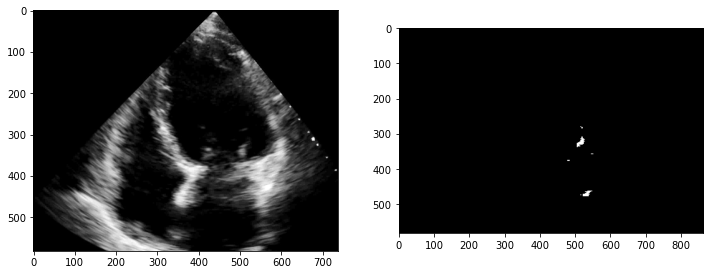

In [395]:
plot_test_data(test_data[1]['video'], predictions[0]['prediction'])

In [354]:
save_zipped_pickle(predictions, 'my_predictions.pkl')

### Preprocessing

In [12]:
def fit_model(X_train, y_train, X_val, y_val):
    model = get_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    history = model.fit(X_train, y_train, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=13, 
                    validation_data=(X_val, y_val), 
                    shuffle=False)
    plot_loss(history)
    y_val_pred = model.predict(X_val) > 0.5
    score = evaluate_frame(y_val_pred, y_val)
    return score, model

def train_k_fold(X, y, fold_num=5):
    kf = KFold(n_splits=fold_num, random_state=None, shuffle=False)
    kf.get_n_splits(X)
    test_score = 0.0
    
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        score, _ = fit_model(X_train, y_train, X_val, y_val)

        print('The obtained iou score is : ',score)
        test_score += score
    print("Validation score: %f"%(test_score/fold_num))
    
def train_k_fold_predict(X, y, test_data, fold_num=5):
    kf = KFold(n_splits=fold_num, random_state=None, shuffle=False)
    kf.get_n_splits(X)
    test_score = 0.0
    models = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        score, model = fit_model(X_train, y_train, X_val, y_val)
        models.append(model)
        print('The obtained iou score is : ',score)
        test_score += score
    
    print("Validation score: %f"%(test_score/fold_num))
    
    predictions = []
    for d in tqdm(test_data):
        res = []
        for index in range(d['video'].shape[2]):
            test_img = cv2.resize(d['video'][:, :, index],(IMG_HEIGHT, IMG_WIDTH)).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
            y_pred = np.zeros()
            for model in models:
                
            mask = (model.predict(test_img) > 0.3).reshape(IMG_HEIGHT, IMG_WIDTH).astype(float)
            mask = cv2.resize(mask,(d['video'].shape[1], d['video'].shape[0]), interpolation = cv2.INTER_NEAREST)
            res.append(mask)
        res = np.swapaxes(np.swapaxes(np.array(res), 0, 2), 0, 1)
        assert res.shape == d['video'].shape
        # DATA Strucure
        predictions.append({
            'name': d['name'],
            'prediction': res.astype(bool)
            }
        )


In [13]:
train_k_fold(X, y) 

Epoch 1/5
16/16 [==============================] - 46s 3s/step - loss: 0.6093 - accuracy: 0.7805 - val_loss: 0.1898 - val_accuracy: 0.9906
Epoch 2/5
16/16 [==============================] - 49s 3s/step - loss: 0.1374 - accuracy: 0.9912 - val_loss: 0.0746 - val_accuracy: 0.9906
Epoch 3/5
16/16 [==============================] - 46s 3s/step - loss: 0.0575 - accuracy: 0.9912 - val_loss: 0.0584 - val_accuracy: 0.9906
Epoch 4/5
16/16 [==============================] - 49s 3s/step - loss: 0.0408 - accuracy: 0.9912 - val_loss: 0.0336 - val_accuracy: 0.9906
Epoch 5/5
16/16 [==============================] - 45s 3s/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0242 - val_accuracy: 0.9906
The obtained iou score is :  0.0
Epoch 1/5
 1/16 [>.............................] - ETA: 1:00 - loss: 0.6978 - accuracy: 0.4230

KeyboardInterrupt: 

### Make Prediction

In [ ]:
# make prediction for test
# predictions = []
# for d in test_data:
#     prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
#     height = prediction.shape[0]
#     width = prediction.shape[1]
#     prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
#     # DATA Strucure
#     predictions.append({
#         'name': d['name'],
#         'prediction': prediction
#         }
#     )

In [ ]:
# save in correct format
# save_zipped_pickle(predictions, 'my_predictions.pkl')